In [44]:
%reset -f
import os
import sys
import pathlib
# import argparse

sys.path.append('/home/psimmerl/mds_analysis')

import math
import numpy as np
import numba as nb
from math import ceil, floor

import pickle

# from src.helper_functions import alert, Table
# from src.histo_utilities import std_color_list as SCL

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
# from ROOT import TNtuple, TTree, TBranch, RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

from src.helper_functions import alert, Table, weight_calc

# **************************** #
OUT_DIR = 'reports/weekly/2024-03-27'
LOCAL_OUT_DIR = '/home/psimmerl/mds_analysis'  # os.getcwd()

DATA_VERSION = '6'
LUMI = 23.02 * 1000
PI = rt.TMath.Pi()

LOCAL_DATA_DIR = '/home/psimmerl/mds_analysis/data'  # os.getcwd() + '/data/raw'
DATA_DIR = LOCAL_DATA_DIR#'TIER2' if 'caltech' in os.uname()[1] else 'LOCAL'
OUT_DIR = f'{LOCAL_OUT_DIR}/{OUT_DIR}'

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL

SCL = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

gc = []

# **************** #

TAG_CATEGORY = ('csccsc', 'cscdt')[0]
SIZE_VAR = TAG_CATEGORY[3:]

if 'csccsc' in TAG_CATEGORY:
    LOW_MET, HIGH_MET = 75, 150
if 'cscdt' in TAG_CATEGORY:
    LOW_MET, HIGH_MET = 75, 150

FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_l1_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_l1_rdf.root'
# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_l1_rdf.root'
FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_l1_rdf.root'

# **************** #
print(f'{TAG_CATEGORY=}')
print(f'{SIZE_VAR=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC).Filter('met < 200'),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3).Filter('met < 200'),
}

print('Events Read:')
for key, rdf in rdfs.items():
    if SIZE_VAR == 'csc':
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')
    elif SIZE_VAR == 'dt':
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf

TAG_CATEGORY='csccsc'
SIZE_VAR='csc'

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_csccsc_l1_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_csccscOOT_l1_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-03-27'

Events Read:
  mc = 3,221 (1,945.77)
  r3 = 65,511 (65,511.00)


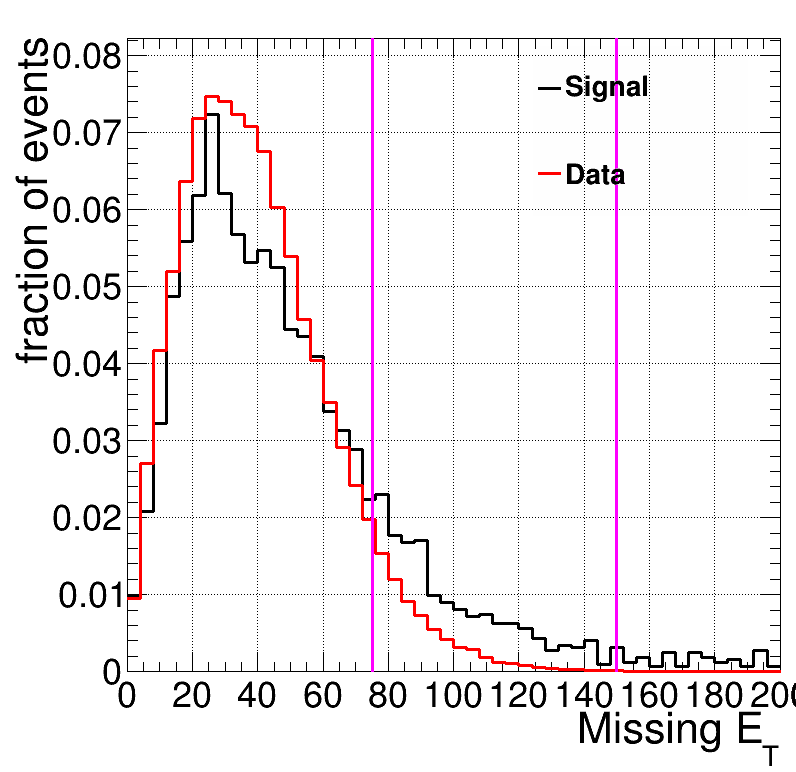

In [45]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.67, 0.72, 0.94, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

xv = 'met'
txy_label = f';Missing E_{{T}};fraction of events'
form =(txy_label,50,0,200)
# **** #

h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,).GetValue()
h2 = rdfs['r3'].Histo1D(('Data',*form),xv,).GetValue()

hhs = [h1,h2]
# hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    if hmax < 1 and nev:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')

low_line = TLine(LOW_MET,0,LOW_MET,hmax*1.1)
high_line = TLine(HIGH_MET,0,HIGH_MET,hmax*1.1)
low_line.SetLineColor(rt.kMagenta)
high_line.SetLineColor(rt.kMagenta)
low_line.SetLineWidth(3)
high_line.SetLineWidth(3)

low_line.Draw()
high_line.Draw()

legend.Draw()
canvas.Draw()


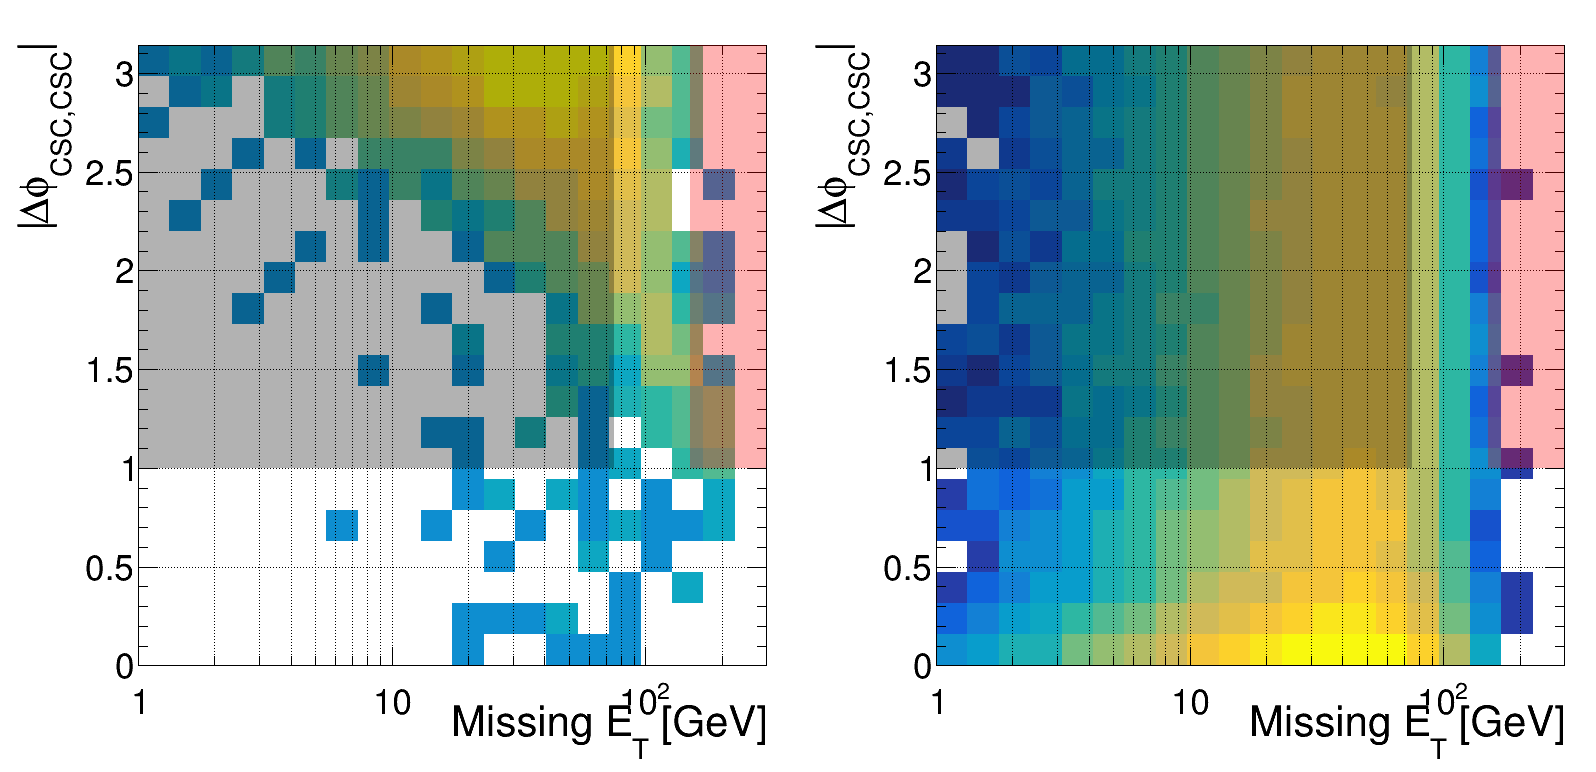

In [46]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)

nb = 20
xv, yv = 'met', 'tag_dPhi'
txy_label = f';Missing E_{{T}} [GeV];|#Delta#phi_{{CSC,{SIZE_VAR.upper()}}}|;fraction of events'
bins = (nb, np.logspace(0, np.log10(300), nb+1), nb, np.linspace(0,PI,nb+1))
logxyz = (True, False, True)

# **** #

h1 = rdfs['mc'].Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
h2 = rdfs['r3'].Histo2D(('Data',txy_label,*bins),xv,yv).GetValue()

hhs = [h1,h2]
# hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
for ih, hh in enumerate(hhs):
    canvas.cd(ih + 1).SetGrid()
    if logxyz[0]:
        canvas.cd(ih + 1).SetLogx()
    if logxyz[1]:
        canvas.cd(ih + 1).SetLogy()
    if logxyz[2]:
        canvas.cd(ih + 1).SetLogz()
    
    # hh.Scale(1/hh.Integral())
    # hh.SetMinimum(0)
    # hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('col')

    bl = TBox(hh.GetXaxis().GetXmin(),
              1.0,#hh.GetYaxis().GetXmin(),
              LOW_MET,#hh.GetXaxis().GetXmax(),
              hh.GetYaxis().GetXmax())
    bl.SetLineColorAlpha(rt.kBlack, 1.0)
    bl.SetLineWidth(3)
    bl.SetFillColorAlpha(rt.kBlack, 0.3)
    bl.Draw()
    
    bh = TBox(HIGH_MET,#hh.GetXaxis().GetXmin(),
              1.0,#hh.GetYaxis().GetXmin(),
              hh.GetXaxis().GetXmax(),
              hh.GetYaxis().GetXmax())
    bh.SetLineColorAlpha(rt.kRed, 1.0)
    bh.SetLineWidth(3)
    bh.SetFillColorAlpha(rt.kRed, 0.3)
    bh.Draw()
    
    gc.extend([bl,bh])


# legend.Draw()
canvas.Draw()


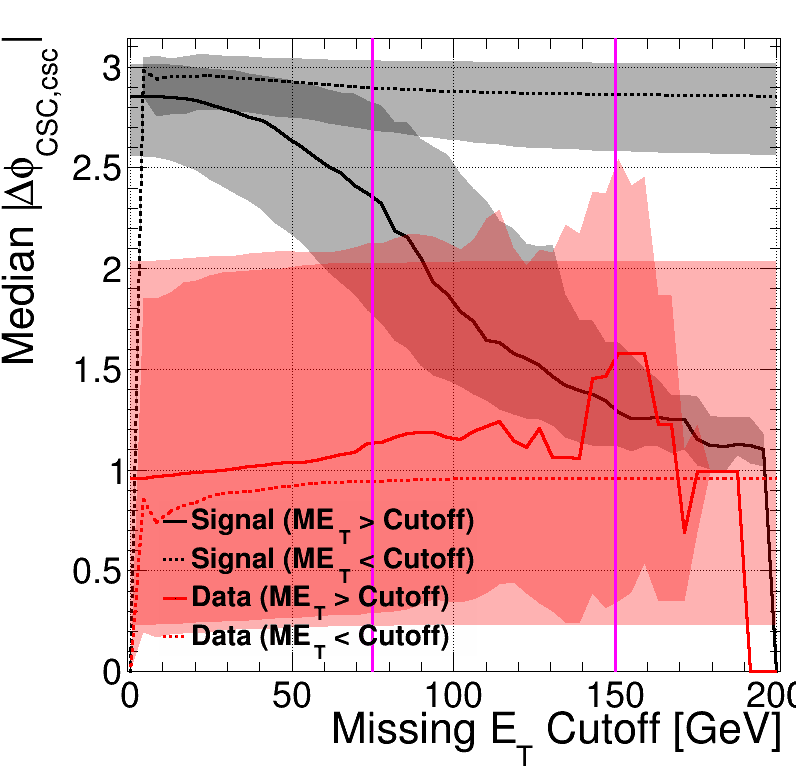

In [47]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

# legend = TLegend(0.55, 0.70, 0.97, 0.95)
legend = TLegend(0.20, 0.15, 0.60, 0.35)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.1)

mets = np.linspace(0,200,50)
dphiL_mc = [rdfs['mc'].Filter(f'met > {met}').AsNumpy(['tag_dPhi'])['tag_dPhi'] for met in mets]
dphiL_r3 = [rdfs['r3'].Filter(f'met > {met}').AsNumpy(['tag_dPhi'])['tag_dPhi'] for met in mets]
dphiH_mc = [rdfs['mc'].Filter(f'met < {met}').AsNumpy(['tag_dPhi'])['tag_dPhi'] for met in mets]
dphiH_r3 = [rdfs['r3'].Filter(f'met < {met}').AsNumpy(['tag_dPhi'])['tag_dPhi'] for met in mets]

# **** #
values = [dphiL_mc,dphiH_mc,dphiL_r3,dphiH_r3]

xlabel = 'Missing E_{T} Cutoff [GeV]'
ylabel = f'Median |#Delta#phi_{{CSC,{SIZE_VAR}}}|'#f'Mean 

names = ['Signal (ME_{T} > Cutoff)', 'Signal (ME_{T} < Cutoff)', 'Data (ME_{T} > Cutoff)', 'Data (ME_{T} < Cutoff)']
hmin, hmax = 0, PI
for igr, val in enumerate(values):
    if 'median' in ylabel.lower():
        yy = np.array([[np.median(v),np.median(v)-np.percentile(v,25),np.percentile(v,75)-np.median(v)] if len(v) else [0,0,0] for v in val])
    elif 'mean' in ylabel.lower():
        yy = np.array([[v.mean(),v.mean()-np.percentile(v,25),np.percentile(v,75)-v.mean()] if len(v) else [0,0,0] for v in val])
    gr = TGraphAsymmErrors(len(mets),mets,yy[:,0]*1,mets*0,mets*0,yy[:,1]*1,yy[:,2]*1)
    gr.GetXaxis().SetLimits(np.min(mets)-1, np.max(mets)+1)
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[0 if 'Signal' in names[igr] else 1])
    gr.SetLineStyle(rt.kDashed if '<' in names[igr] else rt.kSolid)
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)
    gr.Draw(('' if igr else 'A')+' L3')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

# **** #
low_line = TLine(LOW_MET,hmin,LOW_MET,hmax)
high_line = TLine(HIGH_MET,hmin,HIGH_MET,hmax)
low_line.SetLineColor(rt.kMagenta)
high_line.SetLineColor(rt.kMagenta)
low_line.SetLineWidth(3)
high_line.SetLineWidth(3)

low_line.Draw()
high_line.Draw()

legend.Draw()
canvas.Draw()


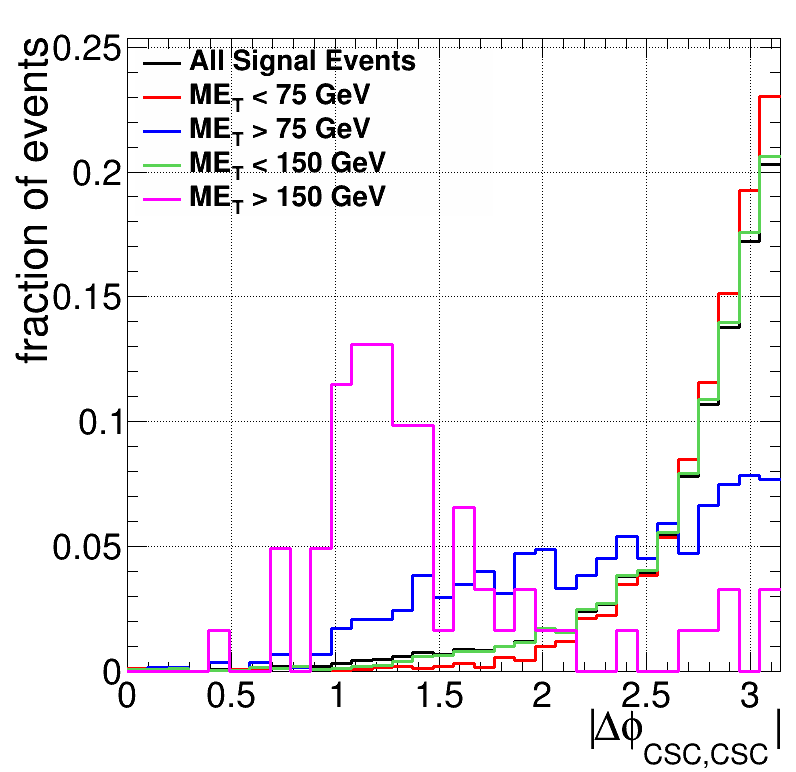

In [48]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

legend = TLegend(0.17, 0.72, 0.62, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

xv = 'tag_dPhi'

txy_label = f';|#Delta#phi_{{CSC,{SIZE_VAR.upper()}}}|;fraction of events'

form =(txy_label,32,0,PI)
# **** #

h1 = rdfs['mc'].Histo1D(('All Signal Events',*form),xv,).GetValue()
h2 = rdfs['mc'].Filter(f'met<{LOW_MET}').Histo1D((f'ME_{{T}} < {LOW_MET} GeV',*form),xv).GetValue()
h3 = rdfs['mc'].Filter(f'met>{LOW_MET}').Histo1D((f'ME_{{T}} > {LOW_MET} GeV',*form),xv).GetValue()
h4 = rdfs['mc'].Filter(f'met<{HIGH_MET}').Histo1D((f'ME_{{T}} < {HIGH_MET} GeV',*form),xv).GetValue()
h5 = rdfs['mc'].Filter(f'met>{HIGH_MET}').Histo1D((f'ME_{{T}} > {HIGH_MET} GeV',*form),xv).GetValue()

hhs = [h1,h2,h3,h4,h5]
# hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    if hmax <= 1 and nev:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')


legend.Draw()
canvas.Draw()


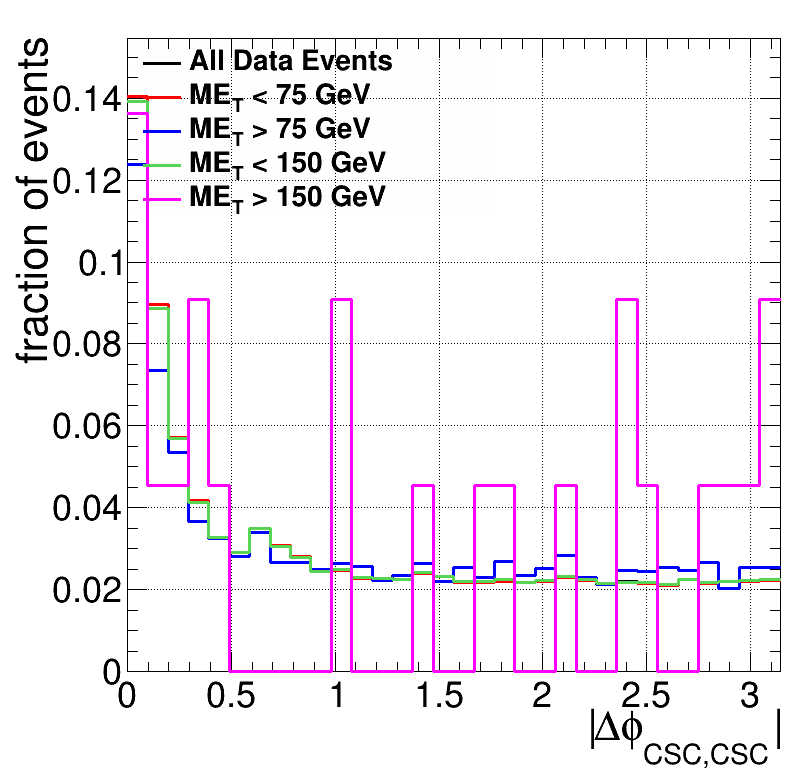

In [49]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()

legend = TLegend(0.17, 0.72, 0.62, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

xv = 'tag_dPhi'

txy_label = f';|#Delta#phi_{{CSC,{SIZE_VAR.upper()}}}|;fraction of events'

form =(txy_label,32,0,PI)
# **** #

h1 = rdfs['r3'].Histo1D(('All Data Events',*form),xv,).GetValue()
h2 = rdfs['r3'].Filter(f'met<{LOW_MET}').Histo1D((f'ME_{{T}} < {LOW_MET} GeV',*form),xv).GetValue()
h3 = rdfs['r3'].Filter(f'met>{LOW_MET}').Histo1D((f'ME_{{T}} > {LOW_MET} GeV',*form),xv).GetValue()
h4 = rdfs['r3'].Filter(f'met<{HIGH_MET}').Histo1D((f'ME_{{T}} < {HIGH_MET} GeV',*form),xv).GetValue()
h5 = rdfs['r3'].Filter(f'met>{HIGH_MET}').Histo1D((f'ME_{{T}} > {HIGH_MET} GeV',*form),xv).GetValue()

hhs = [h1,h2,h3,h4,h5]
# hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    if hmax <= 1 and nev:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')


legend.Draw()
canvas.Draw()


In [50]:
# canvas = TCanvas('','',800,800)
# canvas.SetGrid()
# canvas.SetLogy()

# # legend = TLegend(0.17, 0.72, 0.62, 0.94)
# legend = TLegend(0.57, 0.72, 0.97, 0.94)
# legend.SetBorderSize(0)
# legend.SetFillColorAlpha(rt.kBlack, 0.2)
# legend.SetTextSize(0.04)
# legend.SetMargin(0.15)

# xv = 'met'

# txy_label = ';Missing E_{T} [GeV];count'

# form =(txy_label,20,0,200)
# # **** #

# h1 = rdfs['mc'].Histo1D(('Signal (after cuts)',*form),xv).GetValue()
# h2 = rdfs['r3'].Histo1D(('Data (after cuts)',*form),xv).GetValue()
# h3 = rdfs['mc_raw'].Histo1D(('Signal (no cuts)',*form),xv).GetValue()
# h4 = rdfs['r3_raw'].Histo1D(('Data (HLT only)',*form),xv).GetValue()
# # h2 = rdfs['mc'].Filter(f'met<75').Histo1D(('ME_{T} < 75 GeV',*form),xv).GetValue()
# # h3 = rdfs['mc'].Filter(f'met>75').Histo1D(('ME_{T} > 75 GeV',*form),xv).GetValue()
# hhs = [h1,h2,h3,h4]
# hmax = max([h.GetMaximum() for h in hhs])
# # hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
# for ih, hh in enumerate(hhs):
#     if hmax < 1:
#         hh.Scale(1/hh.Integral())
#     # hh.SetMinimum(0)
#     hh.SetMaximum(hmax*1.1)
#     hh.SetLineColor(SCL[ih])
#     hh.SetLineWidth(3)
#     hh.Draw('hist same')
#     legend.AddEntry(hh, hh.GetName(), 'L')


# legend.Draw()
# canvas.Draw()

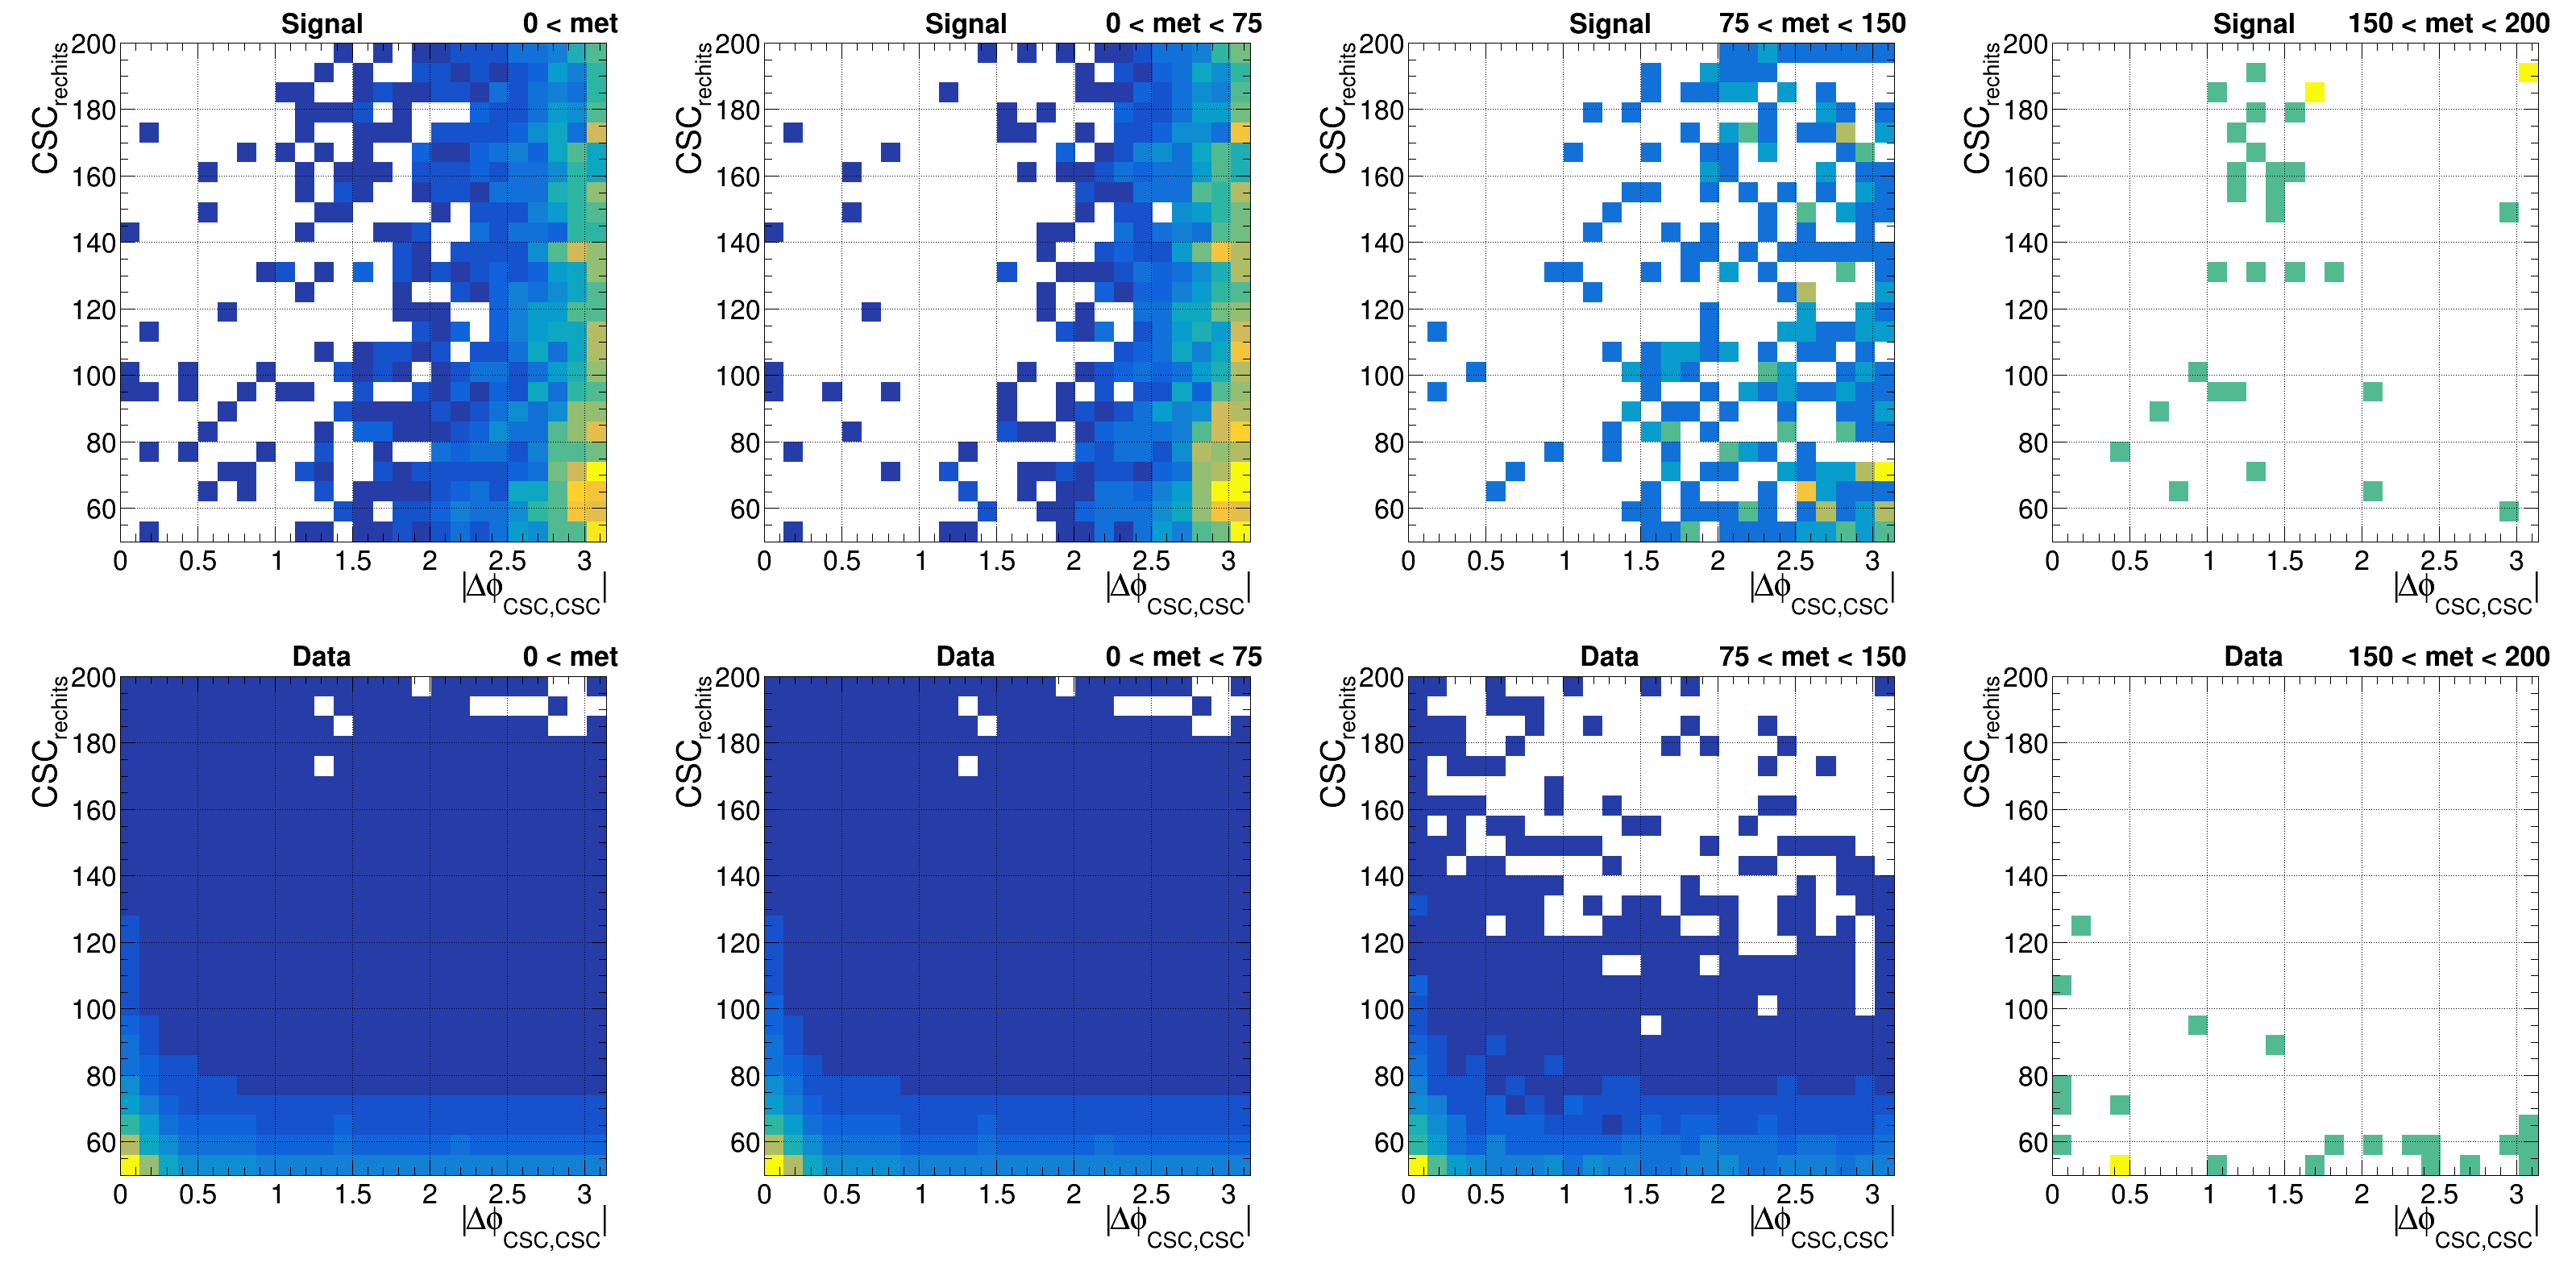

In [51]:
canvas = TCanvas('','',4*800,2*800)
canvas.Divide(4,2)

latex = TLatex()
latex.SetTextSize(0.05)

form = ('',f';|#Delta#phi_{{CSC,{SIZE_VAR.upper()}}}|;{SIZE_VAR.upper()}_{{rechits}};',25,0,PI,25,50,200)
for i, ft in enumerate([f'0 < met',
                        f'(0 < met) & (met < {LOW_MET})',
                        f'({LOW_MET} < met) & (met < {HIGH_MET})',
                        f'({HIGH_MET} < met) & (met < 200)']):
    for j in range(2):
        canvas.cd(i+1 + 4*j).SetGrid()
        # canvas.cd(i+1).SetLogz()

        rdfn = ['mc', 'r3'][j]
        hh = rdfs[rdfn].Filter(ft).Histo2D(form,'tag_dPhi','tag_size')
        hh.Draw('col')

        _ft = ft.replace('(', '').replace(')', '').replace('met & met', 'met')
        latex.SetTextAlign(33)
        latex.DrawLatexNDC(1, 1, _ft)
        latex.SetTextAlign(23)
        latex.DrawLatexNDC(0.5, 1, 'Data' if j else 'Signal')
        gc.append(hh)
canvas.Draw()

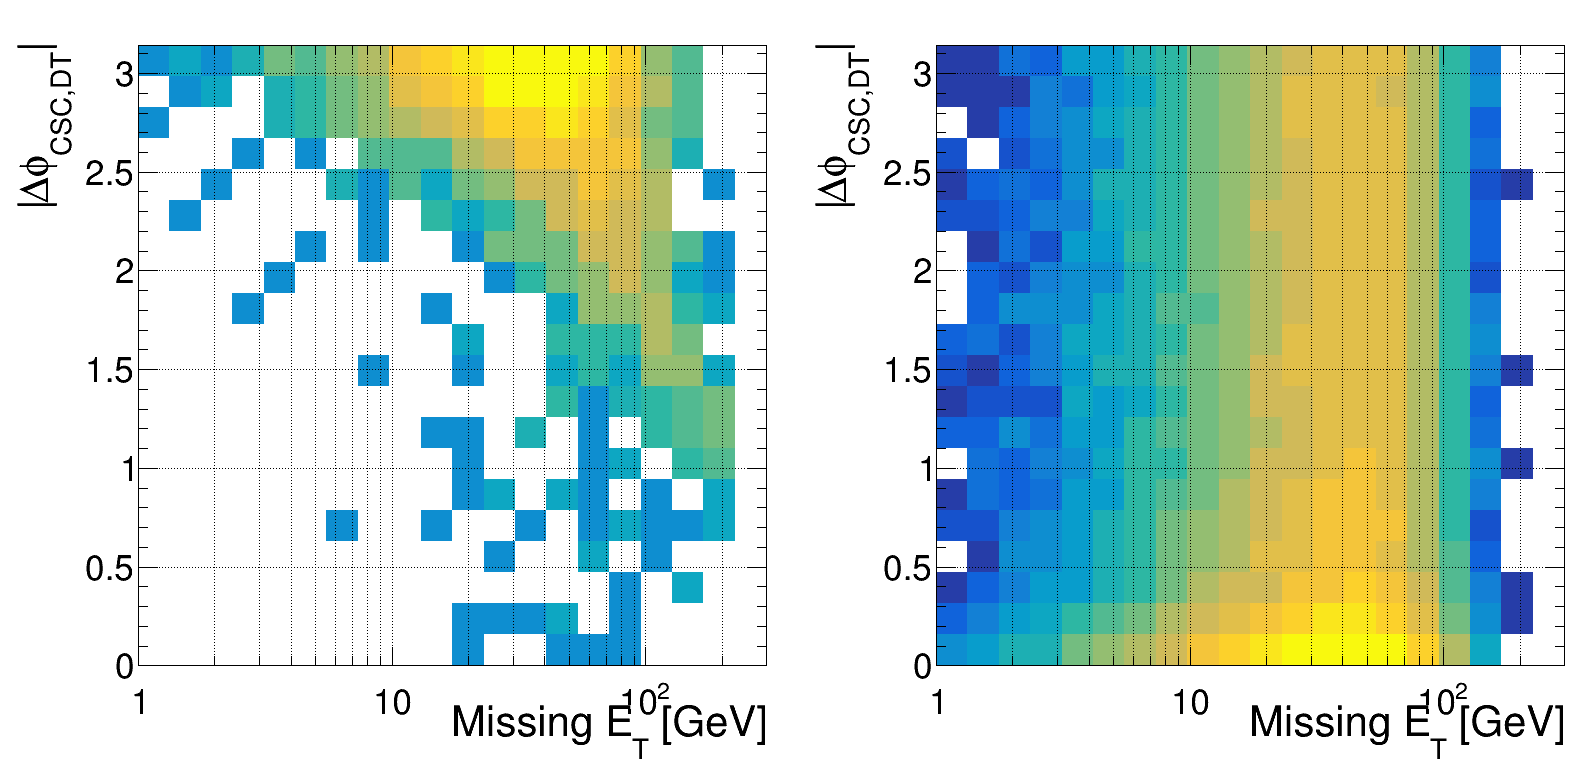

In [52]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)
# canvas.SetGrid()

# legend = TLegend(0.17, 0.72, 0.62, 0.94)
# legend.SetBorderSize(0)
# legend.SetFillColorAlpha(rt.kBlack, 0.2)
# legend.SetTextSize(0.04)
# legend.SetMargin(0.15)

nb = 20
xv, yv = 'met', 'tag_dPhi'
txy_label = ';Missing E_{T} [GeV];|#Delta#phi_{CSC,DT}|;fraction of events'
bins = (nb, np.logspace(0, np.log10(300), nb+1), nb, np.linspace(0,PI,nb+1))
logxyz = (True, False, True)

# nb = 20
# xv, yv = 'met', 'dtSize'
# txy_label = ';Missing E_{T} [GeV];DT N_{Rechits};fraction of events'
# bins = (nb, np.logspace(0, np.log10(300), nb+1), nb, np.logspace(np.log10(40), np.log10(1000), nb+1))
# logxyz = (True, True, True)

# nb = 20
# xv, yv = 'dtSize', 'tag_dPhi'
# txy_label = ';DT N_{Rechits};|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.logspace(np.log10(40), np.log10(1000), nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (True, False, True)

# nb = 20
# xv, yv = 'cscEta', 'tag_dPhi'
# txy_label = ';#eta_{CSC};|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.linspace(-2, 2, nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'dtPhi', 'tag_dPhi'
# txy_label = ';#phi_{CSC};|#Delta#phi_{CSC,DT}|;fraction of events'
# bins = (nb, np.linspace(-np.pi, np.pi, nb+1), nb, np.linspace(0,PI,nb+1))
# logxyz = (False, False, True)


# **** #

h1 = rdfs['mc'].Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
h2 = rdfs['r3'].Histo2D(('Data',txy_label,*bins),xv,yv).GetValue()

hhs = [h1,h2]
# hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
for ih, hh in enumerate(hhs):
    canvas.cd(ih + 1).SetGrid()
    if logxyz[0]:
        canvas.cd(ih + 1).SetLogx()
    if logxyz[1]:
        canvas.cd(ih + 1).SetLogy()
    if logxyz[2]:
        canvas.cd(ih + 1).SetLogz()
    
    # hh.Scale(1/hh.Integral())
    # hh.SetMinimum(0)
    # hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('col')


# legend.Draw()
canvas.Draw()
